## OKAERTool and PyNavis initialization

Board: XEM6310 Spartan-6

In [1]:
import sys
import os
import time

# Add the parent directory to the path to import pyOKAERTool (only if the package is not installed)
# sys.path.insert(0, os.path.abspath('..'))
import pyOKAERTool as okt
from pyNAVIS import *
import os

# Define bitfile path
bitfile_path = 'bitfiles/CNAS_okaertool_XEM6310.bit'
# bitfile_path = None  # Set to None if no .bit file is to be used

# Validate the existence of the .bit file
if bitfile_path is None:
    None
elif not os.path.exists(bitfile_path):
    print(f"El archivo .bit no existe en la ruta especificada: {bitfile_path}")
    sys.exit(1)

# Create a new intance of the OkaerTool class and initialize it
okaer = okt.Okaertool(bit_file=bitfile_path)
okaer.init()

# Create a new instance of the PyNAVIS class
settings = MainSettings(num_channels=64, mono_stereo=1, on_off_both=1, address_size=4, ts_tick=0.01, bin_size=10000)

02/24/26 05:53:30 PM - INFO : Device product ID: 22, product name: XEM6310-LX150, USB speed: 2,
02/24/26 05:53:30 PM - INFO : USB 2.0 HighSpeed. USB block size set to 1 KB
02/24/26 05:53:30 PM - INFO : okaertool initialized as idle


## NAS configuration

In [2]:
import re
import os

config_file_path = './CFBank_64_20_22000.vhd'

def _tok_to_int(tok):
    tok = tok.strip().rstrip(',').strip()
    if tok.lower().startswith('x"') and tok.endswith('"'):
        return int(tok[2:-1], 16)
    if tok.lower().startswith('0x'):
        return int(tok, 16)
    m = re.match(r'16#([0-9A-Fa-f]+)#', tok)
    if m:
        return int(m.group(1), 16)
    if tok.isdigit():
        return int(tok, 10)
    raise ValueError(f"Unrecognized token: {tok!r}")

def parse_cascade_vhd(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    text = open(path, 'r', encoding='utf-8', errors='ignore').read()

    # Find successive groups of the four parameters in the file order
    pattern = re.compile(
        r'FREQ_DIV\s*=>\s*(?P<f>[^,\n;]+)\s*,\s*'
        r'SPIKES_DIV_FB\s*=>\s*(?P<fb>[^,\n;]+)\s*,\s*'
        r'SPIKES_DIV_OUT\s*=>\s*(?P<out>[^,\n;]+)\s*,\s*'
        r'SPIKES_DIV_BPF\s*=>\s*(?P<bpf>[^,\n;]+)',
        re.IGNORECASE | re.DOTALL
    )

    values = []
    for m in pattern.finditer(text):
        f = _tok_to_int(m.group('f'))
        fb = _tok_to_int(m.group('fb'))
        out = _tok_to_int(m.group('out'))
        bpf = _tok_to_int(m.group('bpf'))
        values.extend([f, fb, out, bpf])

    return values

# Define default parameters for the filters
PDM2Spikes_DEFAULT_parameter = [0x0005, 0x0006, 0x734B, 0x39C8]
I2S2Spikes_DEFAULT_parameter = [0x000F]
CASCADE_FILTER_DEFAULT_parameter = parse_cascade_vhd(config_file_path)

# quick validation / pretty print
filters = len(CASCADE_FILTER_DEFAULT_parameter) // 4
print(f"Parsed {filters} filters ({len(CASCADE_FILTER_DEFAULT_parameter)} values).")
print("CASCADE_FILTER_DEFAULT_parameter = [")
for v in CASCADE_FILTER_DEFAULT_parameter:
    # print as hex literal (4 hex digits minimum)
    width = max(2, (v.bit_length() + 3) // 4)
    print(f"    0x{v:0{width}X},")
print("]")

# Reset the OkaerTool
okaer.reset_board(mode='internal')

# Configure the PDM2Spikes (left and right) for both NAS
register_address = 0x0000
okaer.logger.info("Configuring PDM2Spikes modules")
# Left cochlea
okaer.logger.info("Left cochlea")
for value in PDM2Spikes_DEFAULT_parameter:
    okaer.set_config('port_a', register_address, value)
    # okaer.set_config('port_b', register_address, value)
    register_address += 1
# Right cochlea
okaer.logger.info("Right cochlea")
for value in PDM2Spikes_DEFAULT_parameter:
    okaer.set_config('port_a', register_address, value)
    # okaer.set_config('port_b', register_address, value)
    register_address += 1

register_address = 0x08
okaer.logger.info("Configuring I2S2Spikes modules")
# Configure I2S2Spikes modules for both NAS
for value in I2S2Spikes_DEFAULT_parameter:
    okaer.set_config('port_a', register_address, value)
    # okaer.set_config('port_b', register_address, value)

# Configure the filters for CASCADE NAS
okaer.logger.info("Configuring filters for Cascade NAS")
# Left cochlea
register_address = 0x09
okaer.logger.info("Left cochlea")
for value in CASCADE_FILTER_DEFAULT_parameter:
    okaer.set_config('port_a', register_address, value)
    register_address += 1
    # # Config only 32 filters
    # if register_address >= 0x09 + 32*4:
    #     break
# Right cochlea
register_address = 0x010D
okaer.logger.info("Right cochlea")
for value in CASCADE_FILTER_DEFAULT_parameter:
    okaer.set_config('port_a', register_address, value)
    register_address += 1
    # # Config only 32 filters
    # if register_address >= 0x010D + 32*4:
    #     break

02/24/26 05:53:32 PM - INFO : Board reset in mode: internal
02/24/26 05:53:32 PM - INFO : Configuring PDM2Spikes modules
02/24/26 05:53:32 PM - INFO : Left cochlea
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x0 and value 0x5
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x1 and value 0x6
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x2 and value 0x734b
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x3 and value 0x39c8
02/24/26 05:53:32 PM - INFO : Right cochlea
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x4 and value 0x5
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x5 and value 0x6
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x6 and value 0x734b
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x7 and value 0x39c8
02/24/26 05:53:32 PM - INFO : Configuring I2S2Spikes modules
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x8 and value 0xf

Parsed 65 filters (260 values).
CASCADE_FILTER_DEFAULT_parameter = [
    0x04,
    0x7CB1,
    0x7CB1,
    0x2025,
    0x04,
    0x6F93,
    0x6F93,
    0x2025,
    0x02,
    0x77CE,
    0x77CE,
    0x2025,
    0x02,
    0x6B33,
    0x6B33,
    0x2025,
    0x03,
    0x7FE5,
    0x7FE5,
    0x2025,
    0x03,
    0x7271,
    0x7271,
    0x2025,
    0x03,
    0x6666,
    0x6666,
    0x2025,
    0x04,
    0x7289,
    0x7289,
    0x2025,
    0x02,
    0x7AFB,
    0x7AFB,
    0x2025,
    0x02,
    0x6E0B,
    0x6E0B,
    0x2025,
    0x02,
    0x6277,
    0x6277,
    0x2025,
    0x03,
    0x757A,
    0x757A,
    0x2025,
    0x03,
    0x691E,
    0x691E,
    0x2025,
    0x04,
    0x7593,
    0x7593,
    0x2025,
    0x02,
    0x7E3F,
    0x7E3F,
    0x2025,
    0x02,
    0x70F7,
    0x70F7,
    0x2025,
    0x02,
    0x6514,
    0x6514,
    0x2025,
    0x03,
    0x7898,
    0x7898,
    0x2025,
    0x03,
    0x6BE8,
    0x6BE8,
    0x2025,
    0x04,
    0x78B1,
    0x78B1,
    0x2025,
    0x04,
 

02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x48 and value 0x2025
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x49 and value 0x2
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x4a and value 0x6514
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x4b and value 0x6514
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x4c and value 0x2025
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x4d and value 0x3
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x4e and value 0x7898
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x4f and value 0x7898
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x50 and value 0x2025
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x51 and value 0x3
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x52 and value 0x6be8
02/24/26 05:53:32 PM - INFO : Configuring port_a with address 0x53 and value 0x6be8
0

## Experiment

### Audio functions

In [3]:
import sounddevice as sd
import soundfile as sf
import tkinter as tk
from tkinter import filedialog

def list_output_devices():
    """Prints all available audio output devices and their IDs."""
    print(sd.query_devices())

def select_wav_file():
    root = tk.Tk()
    root.withdraw()  # Hide the main window
    file_path = filedialog.askopenfilename(title="Select a WAV file", filetypes=[("WAV files", "*.wav")])
    return file_path

def get_wav_header_info(file_path):
    """Extracts metadata (features) from the WAV header."""
    with sf.SoundFile(file_path) as f:
        info = {
            "samplerate": f.samplerate,
            "channels": f.channels,
            "subtype": f.subtype,      # Bit depth (e.g., PCM_16)
            "format": f.format,        # File format (WAV, FLAC, etc.)
            "frames": f.frames,        # Total number of audio samples
            "duration_sec": len(f) / f.samplerate
        }
    return info

def play_audio_on_device(file_path, device_id, block=True):
    """
    Plays a WAV file through a specific output interface.
    :param file_path: Path to the .wav file
    :param device_id: The ID of the device (from list_output_devices)
    """
    try:
        # Load the audio file
        data, fs = sf.read(file_path)
        
        # Set the default output device
        sd.default.device = device_id
        
        print(f"Playing on device {device_id}...")
        sd.play(data, fs)
        if block:
            sd.wait()  # Wait until the file is finished playing
        print("Playback finished.")
        
    except Exception as e:
        print(f"Error: {e}")

# Defining the ID for the output device
output_device = None

# First, find the ID of your interface (e.g., HDMI, USB Headset, etc.). Use the ID in the function (replace '1' with your actual device ID)
# play_audio_on_device('my_audio.wav', device_id=1)
if output_device is None:
    list_output_devices()
    output_device = int(input("Please set the output_device variable to the ID of your desired output device: "))


   0 Asignador de sonido Microsoft - Output, MME (0 in, 2 out)
<  1 Headphones (High Definition Aud, MME (0 in, 2 out)
   2 Altavoces (High Definition Audi, MME (0 in, 2 out)
   3 Digital Audio (S/PDIF) (High De, MME (0 in, 2 out)
   4 Controlador primario de sonido, Windows DirectSound (0 in, 2 out)
   5 Headphones (High Definition Audio Device), Windows DirectSound (0 in, 2 out)
   6 Altavoces (High Definition Audio Device), Windows DirectSound (0 in, 2 out)
   7 Digital Audio (S/PDIF) (High Definition Audio Device), Windows DirectSound (0 in, 2 out)
   8 Altavoces (High Definition Audio Device), Windows WASAPI (0 in, 2 out)
   9 Digital Audio (S/PDIF) (High Definition Audio Device), Windows WASAPI (0 in, 2 out)
  10 Headphones (High Definition Audio Device), Windows WASAPI (0 in, 2 out)
  11 Speakers (HD Audio Speaker), Windows WDM-KS (0 in, 2 out)
  12 SPDIF Out (HD Audio SPDIF out), Windows WDM-KS (0 in, 2 out)
  13 Headphones (HD Audio Headphone), Windows WDM-KS (0 in, 2 out)
  1

### Playing audio and monitoring spikes

In [6]:
# Monitor the inputs
MAX_INPUTS = 3
INPUTS = ['port_a'] # Monitor only port_a where the CNAS outputs are sent. port_b is not used in this configuration
MAX_SPIKES = 100000
USB_TRANSFER_LENGTH = 64 * 1024
# Set USB transfer length and number of buffers
okaer.USB_TRANSFER_LENGTH = USB_TRANSFER_LENGTH
MONITOR_MODE_TEST = 'duration'  # 'duration', 'num_spikes', 'live'

# Reset the okaerTool board before monitoring to ensure a clean state
okaer.reset_board(mode='internal')

# Select and play the audio file
wav_file = select_wav_file()
wav_info = get_wav_header_info(wav_file)
DURATION = wav_info['duration_sec'] + 1  # Set duration to the length of the audio file plus a small buffer
play_audio_on_device(wav_file, output_device, block=False)

02/24/26 05:55:20 PM - INFO : Board reset in mode: internal


Playing on device 5...
Playback finished.


<>:63: SyntaxWarning: "\-" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\-"? A raw string is also an option.
<>:63: SyntaxWarning: "\-" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\-"? A raw string is also an option.
C:\Users\Álvaro\AppData\Local\Temp\ipykernel_35764\411005086.py:63: SyntaxWarning: "\-" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\-"? A raw string is also an option.
  okaer.logger.info(f"\--- Input {INPUTS[i]} ---")
02/24/26 05:55:26 PM - INFO : Monitoring for a duration of 9 seconds
02/24/26 05:55:26 PM - INFO : Timestamp reset
02/24/26 05:55:26 PM - INFO : Starting monitoring - USB buffer: 0.06 MB
02/24/26 05:55:35 PM - INFO : Duration limit reached: 9.46 seconds
02/24/26 05:55:35 PM - INFO : Monitoring completed: 9.48 seconds, 9183232 spikes captured
02/24/26 05:55:35 PM - INFO : Input 0: 9183232 spikes
02/24/26 05:55:35 PM - INFO 

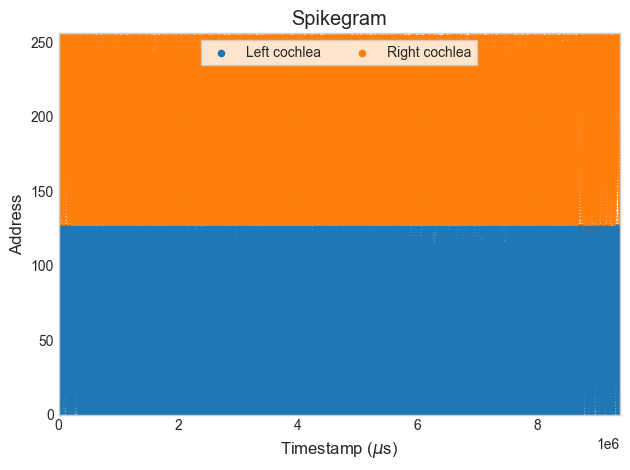

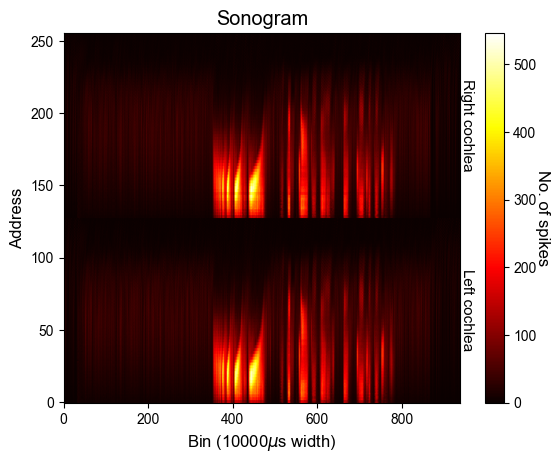

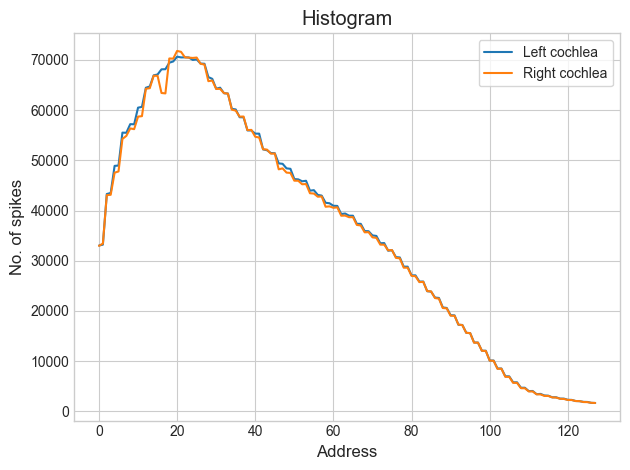

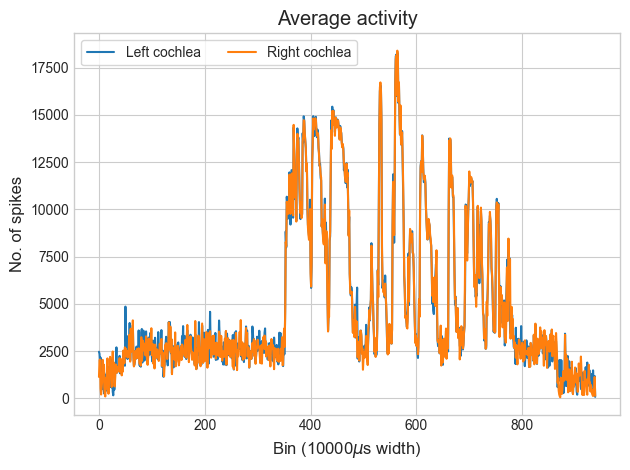

In [7]:
match MONITOR_MODE_TEST:
    case 'duration':
        okaer.logger.info("Monitoring for a duration of %d seconds", DURATION)
        spikes = okaer.monitor(inputs=INPUTS, duration=DURATION)
    case 'num_spikes':
        okaer.logger.info("Monitoring until %d spikes are collected", MAX_SPIKES)
        spikes = okaer.monitor(inputs=INPUTS, max_spikes=MAX_SPIKES)
    case 'live':
        okaer.monitor(inputs=INPUTS, live=True)
        start = time.time()
        spikes = None
        while (time.time() - start) < DURATION:
            # time.sleep(0.01)
            partial_spikes = okaer.get_live_spikes()  # Obtener spikes sin detener
            if partial_spikes is not None:
                if spikes is None:
                    spikes = partial_spikes
                else:
                    [spikes[i].addresses.extend(partial_spikes[i].addresses) for i in range(MAX_INPUTS)]
                    [spikes[i].timestamps.extend(partial_spikes[i].timestamps) for i in range(MAX_INPUTS)]
                    okaer.logger.debug("Collected partial spikes during live monitoring")
            
        final_spikes = okaer.stop_monitor()  # Detener y obtener todos los spikes
        [spikes[i].addresses.extend(final_spikes[i].addresses) for i in range(MAX_INPUTS)]
        [spikes[i].timestamps.extend(final_spikes[i].timestamps) for i in range(MAX_INPUTS)]
        okaer.logger.info("Monitoring in live mode for a duration of %d seconds", DURATION)
    case _:
        okaer.logger.error("Invalid MONITOR_MODE_TEST: %s", MONITOR_MODE_TEST)
        sys.exit(1)

# Check if spikes is not None. If so, finish the script
if spikes is None:
    okaer.logger.error("No spikes were recorded. Exiting the script.")
    sys.exit(1)
    
# Print the number of spikes for each input
for i in range(MAX_INPUTS):
    okaer.logger.info("Input %d: %d spikes", i, spikes[i].get_num_spikes())

# Create pyNAVIS spike_file only if there are spikes for a specific input
okaer.logger.info("Creating spike files for all selected inputs")
spike_files = []
for i in range(MAX_INPUTS):
    if spikes[i].get_num_spikes() > 0:
        spike_files.append(SpikesFile(addresses=spikes[i].addresses, timestamps=spikes[i].timestamps))

# Add this cell BEFORE plotting to verify data integrity
import numpy as np

okaer.logger.info("=== DATA INTEGRITY CHECK ===")

# IMPORTANT: Timestamps are in 10ns ticks (hardware clock period)
TIMESTAMP_TICK_US = 0.01  # Each tick = 10ns = 0.01 microseconds

for i in range(len(spike_files)):
    if len(spike_files[i].timestamps) == 0:
        okaer.logger.warning(f"Input {INPUTS[i]}: No spikes recorded")
        continue
    
    timestamps = np.array(spike_files[i].timestamps)
    addresses = np.array(spike_files[i].addresses)
    
    okaer.logger.info(f"\--- Input {INPUTS[i]} ---")
    okaer.logger.info(f"Total spikes: {len(timestamps)}")
    okaer.logger.info(f"Timestamp range (ticks): {timestamps.min()} - {timestamps.max()}")
    okaer.logger.info(f"Timestamp range (µs): {timestamps.min() * TIMESTAMP_TICK_US:.2f} - {timestamps.max() * TIMESTAMP_TICK_US:.2f}")
    okaer.logger.info(f"Duration (ms): {(timestamps.max() - timestamps.min()) * TIMESTAMP_TICK_US / 1000:.2f}")
    okaer.logger.info(f"Address range: {addresses.min()} - {addresses.max()}")
    
    # Check for timestamp ordering
    if not np.all(timestamps[:-1] <= timestamps[1:]):
        okaer.logger.error(f"Timestamps are NOT in ascending order!")
        bad_idx = np.where(timestamps[:-1] > timestamps[1:])[0][0]
        okaer.logger.error(f"First violation at index {bad_idx}: {timestamps[bad_idx]} > {timestamps[bad_idx+1]}")
    else:
        okaer.logger.info("✓ Timestamps are in ascending order")
    
    # Check for negative timestamps
    if np.any(timestamps < 0):
        okaer.logger.error(f"Found {np.sum(timestamps < 0)} negative timestamps!")
    else:
        okaer.logger.info("✓ No negative timestamps")
    
    # Check timestamp deltas (should be reasonable for audio events)
    if len(timestamps) > 1:
        deltas = np.diff(timestamps)
        mean_delta_ns = np.mean(deltas) * 10  # Convert ticks to nanoseconds
        median_delta_ns = np.median(deltas) * 10
        max_delta_ns = np.max(deltas) * 10
        
        okaer.logger.info(f"Timestamp deltas (ns): mean={mean_delta_ns:.1f}, median={median_delta_ns:.1f}, max={max_delta_ns:.1f}")
        
        # Expected delta for sequential addresses (e.g., ~24 ticks = 240ns)
        if addresses.max() - addresses.min() > 200:  # If we have many addresses
            okaer.logger.info(f"Expected delta for sequential scan: ~240ns (24 ticks @ 10ns)")
    
    # Calculate event rate
    duration_s = (timestamps.max() - timestamps.min()) * TIMESTAMP_TICK_US / 1e6  # Convert to seconds
    if duration_s > 0:
        event_rate = len(timestamps) / duration_s
        okaer.logger.info(f"Event rate: {event_rate:.0f} spikes/sec")
        
        # Check if rate is reasonable (typical audio: 1k-1M events/sec)
        if event_rate > 10_000_000:
            okaer.logger.warning(f"Event rate seems very high: {event_rate:.0f} spikes/sec")
        elif event_rate < 100:
            okaer.logger.warning(f"Event rate seems very low: {event_rate:.0f} spikes/sec")
        else:
            okaer.logger.info("✓ Event rate within reasonable range")
    
    # Check address distribution
    unique_addrs = np.unique(addresses)
    okaer.logger.info(f"Unique addresses: {len(unique_addrs)}")
    okaer.logger.info(f"Address range: {addresses.min()} to {addresses.max()}")
    
    # Check if addresses are sequential (as expected after reset)
    if len(unique_addrs) > 10:
        expected_sequential = np.arange(addresses.min(), addresses.max() + 1)
        if np.array_equal(np.sort(unique_addrs), expected_sequential):
            okaer.logger.info("✓ Addresses are sequential (as expected after reset)")
        else:
            missing = set(expected_sequential) - set(unique_addrs)
            if missing:
                okaer.logger.info(f"Some addresses missing: {sorted(missing)[:10]}...")
    
    # Show distribution for most active addresses
    addr_counts = np.bincount(addresses.astype(int))
    top_10_indices = np.argsort(addr_counts)[-10:][::-1]
    top_10_counts = addr_counts[top_10_indices]
    okaer.logger.info(f"Top 10 addresses by count:")
    for addr, count in zip(top_10_indices, top_10_counts):
        if count > 0:
            okaer.logger.info(f"  Address {addr}: {count} events")

okaer.logger.info("=== END DATA INTEGRITY CHECK ===")

for i in range(len(spike_files)):
    okaer.logger.info("Plotting the spikegram for input %s", INPUTS[i])
    Plots.spikegram(spike_files[i], settings)

for i in range(len(spike_files)):
    okaer.logger.info("Plotting the sonogram for input %s", INPUTS[i])
    Plots.sonogram(spike_files[i], settings)

for i in range(len(spike_files)):
    okaer.logger.info("Plotting the histogram for input %s", INPUTS[i])
    Plots.histogram(spike_files[i], settings)

for i in range(len(spike_files)):
    okaer.logger.info("Plotting the average activity for input %s", INPUTS[i])
    Plots.average_activity(spike_files[i], settings)